# Tutorial 3: performing physical optics propagations.

In this third tutorial, we take the same optical system as in tutorial 2. However, instead of performing ray-traces through the system, we perform physical optics (PO).

In [1]:
#%matplotlib notebook # Uncomment for interactive plots when running the notebook!
import numpy as np

from PyPO.System import System
from PyPO.Enums import FieldComponents, Projections, Objects

s = System()

2025-08-28 15:00:05 - WARNING - System override set to True. 


2025-08-28 15:00:07 - INFO - Added plane plane_focus to system. 


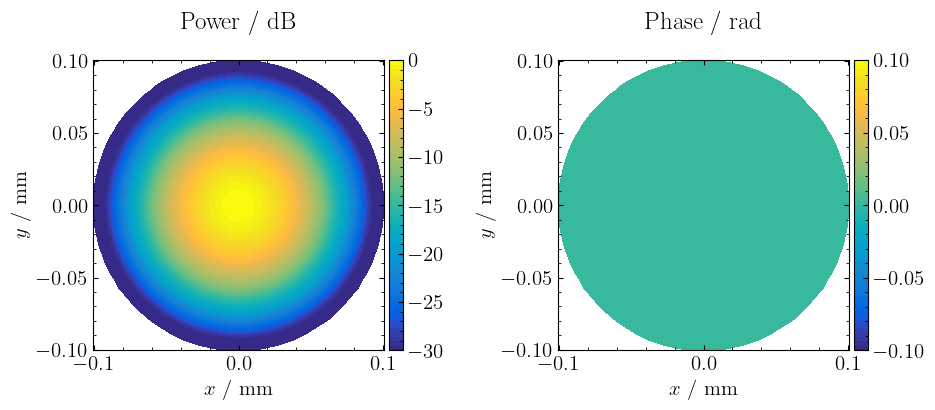

2025-08-28 15:00:08 - INFO - Translated element plane_focus by ('0.000e+00', '0.000e+00', '1.000e+02') millimeters. 


In [2]:
plane_focus = {
            "name"      : "plane_focus",
            "gmode"     : "uv",
            "lims_u"    : np.array([0, 0.1]),
            "lims_v"    : np.array([0, 360]),
            "gridsize"  : np.array([101, 100])
            }

s.addPlane(plane_focus)

GPODict = {                                                                                                                                                                     
    "name"      : "focus",                                                                                                                                  
    "lam"       : 0.01,                                                                                                      
    "w0x"       : 0.05,                                                                                             
    "w0y"       : 0.05,                                                                                             
    "n"         : 1,                                                                                                                             
    "E0"        : 1,                                                                                                                                  
    "dxyz"      : 0,                                                                                                 
    "pol"       : np.array([1, 0, 0])                                                                                                          
}

s.createGaussian(GPODict, "plane_focus")
s.plotBeam2D("focus", FieldComponents.Ex, vmin=-30, vmax=0)

s.translateGrids("plane_focus", np.array([0, 0, 100]))


We start by defining a plane in the upper focus of the ellipsoid. We give it a radius of 0.1 mm. However, we do not place it in the focus just yet. First, we define a Gaussian PO beam on the plane. Because the Gaussian PO beams are always defined with their focus at x=y=z=0, we need to be careful to define this before we translate the focal plane.

The Gaussian beam itself is created by passing a filled dictionary, called a GPODict here, to the `s.createGaussian()` method. The dictionary consists of several fields. The "name" field contains the name by which the field will be stored in the internal fields dictionary of `System`. "lam" sets the wavelength, 0.01 mm in this case. After that, "w0x" and "w0y" set the beamwaist sizes along the x- and y-axis in mm, respectively. The refractive index of the medium in which the beam is defined is set by "n". The peak electric field value at the focus is set by "E0". The astigmatic z-axis distance between the focus of the beam in the x-plane and the y-plane in mm is set by "dxyz". Note that, if this option is used, the focus in the x-plane is placed at z=0 and the focus in the y-plane at z=-dxyz. The final field, "pol", sets the polarisation vector of the Gaussian beam.

In [3]:
ellipse = {
            "name"      : "ellipsoid",
            "pmode"     : "focus",
            "gmode"     : "uv",
            "flip"      : True,
            "focus_1"   : np.array([0, 0, 100]),
            "focus_2"   : np.array([0, 0, -100]),
            "orient"    : "z",
            "ecc"       : 0.5,
            "lims_u"    : np.array([0, 10]),
            "lims_v"    : np.array([0, 360]),
            "gridsize"  : np.array([11, 10])
            }

s.addEllipse(ellipse)

s.autoConverge("focus", "ellipsoid")

plane_t = {
            "name"      : "plane_t",
            "gmode"     : "uv",
            "lims_u"    : np.array([0, 5]),
            "lims_v"    : np.array([0, 360]),
            "gridsize"  : np.array([301, 300])
            }

s.addPlane(plane_t)
s.rotateGrids("plane_t", np.array([45, 0, 0]))

parabola = {
            "name"      : "paraboloid",
            "pmode"     : "focus",
            "gmode"     : "uv",
            "focus_1"   : np.array([0, -100, 0]),
            "vertex"    : np.array([-10, -100, 0]),
            "lims_u"    : np.array([0, 0.5]),
            "lims_v"    : np.array([0, 360]),
            "gcenter"   : np.array([0,-20]),
            "gridsize"  : np.array([301, 300])
            }

s.addParabola(parabola)

2025-08-28 15:00:26 - INFO - Added ellipsoid ellipsoid to system. 
2025-08-28 15:00:26 - WORK - *** Starting auto-convergence ***  
2025-08-28 15:00:26 - WORK - Difference : 1e+99 at gridsize ('1.100e+01', '1.100e+01') 
2025-08-28 15:00:26 - WORK - Difference : 1.1615725237421728 at gridsize ('2.100e+01', '2.100e+01') 
2025-08-28 15:00:26 - WORK - Difference : 0.3879361616092609 at gridsize ('3.100e+01', '3.100e+01') 
2025-08-28 15:00:26 - WORK - Difference : 0.1941199414552841 at gridsize ('4.100e+01', '4.100e+01') 
2025-08-28 15:00:26 - WORK - Difference : 0.1164862760309866 at gridsize ('5.100e+01', '5.100e+01') 
2025-08-28 15:00:26 - WORK - Difference : 0.07770679567422789 at gridsize ('6.100e+01', '6.100e+01') 
2025-08-28 15:00:26 - WORK - Difference : 0.055504897008383125 at gridsize ('7.100e+01', '7.100e+01') 
2025-08-28 15:00:26 - WORK - Difference : 0.04163664402380007 at gridsize ('8.100e+01', '8.100e+01') 
2025-08-28 15:00:26 - WORK - Difference : 0.03239309526907519 at grid

Here, we basically re-create the system from the previous tutorial. However, as we are doing PO now, the size of the reflectors become important. In the previous tutorial we purposefully oversized the off-axis paraboloid reflector for illustrative purposes. This time, we size the paraboloid in such a way that the illuminating beam has an edge taper between -10 and -15 dB.

Also, note that we put the gridsize of the ellipsoid at numpy.array([1,1]). This is, of course, way too low for doing a sensible propagation. However, also note we call the `s.autoConverge()` method with our Gaussian beam and ellipsoid as arguments. This method calculates the necessary gridsize on a surface in order for a converged solution to occur. In this case, it calculates the difference in power on the target as the gridsizes are increased. When this difference falls below a specified threshold ($10^{-2}$ in this case), the method finishes. 

The method returns the gridsizes for reference, but also automatically adjusts the gridsize of the target surface, so that we do not have to manually adjust after the call.

In [4]:
focus_to_ell_PO = {
    "t_name"      : "ellipsoid",
    "s_current"   : "focus",
    "mode"        : "JM",
    "name_JM"     : "JM_ell",
    "epsilon"     : 10
}

s.runPO(focus_to_ell_PO)

ell_to_plane_t_PO = {
    "t_name"      : "plane_t",
    "s_current"   : "JM_ell",
    "mode"        : "JM",
    "name_JM"     : "JM_pt",
    "epsilon"     : 10
}

s.runPO(ell_to_plane_t_PO)

plane_t_to_par_PO = {
    "t_name"      : "paraboloid",
    "s_current"   : "JM_pt",
    "mode"        : "JMEH",
    "name_JM"     : "JM_par",
    "name_EH"     : "EH_par",
    "epsilon"     : 10
}

s.runPO(plane_t_to_par_PO)

2025-08-28 15:00:31 - WORK - *** Starting PO propagation *** 
2025-08-28 15:00:31 - WORK - Propagating focus on plane_focus to ellipsoid, propagation mode: JM. 
2025-08-28 15:00:31 - WORK - Hardware: running 256 CUDA threads per block. 
2025-08-28 15:00:31 - WORK - ... Calculating ... 
2025-08-28 15:00:35 - WORK - *** Finished: 3.756 seconds *** 
2025-08-28 15:00:35 - WORK - *** Starting PO propagation *** 
2025-08-28 15:00:35 - WORK - Propagating JM_ell on ellipsoid to plane_t, propagation mode: JM. 
2025-08-28 15:00:35 - WORK - Hardware: running 256 CUDA threads per block. 
2025-08-28 15:00:35 - WORK - ... Calculating ... 
2025-08-28 15:01:27 - WORK - *** Finished: 52.303 seconds *** 
2025-08-28 15:01:27 - WORK - *** Starting PO propagation *** 
2025-08-28 15:01:27 - WORK - Propagating JM_pt on plane_t to paraboloid, propagation mode: JMEH. 
2025-08-28 15:01:27 - WORK - Hardware: running 256 CUDA threads per block. 
2025-08-28 15:01:27 - WORK - ... Calculating ... 
2025-08-28 15:01:2

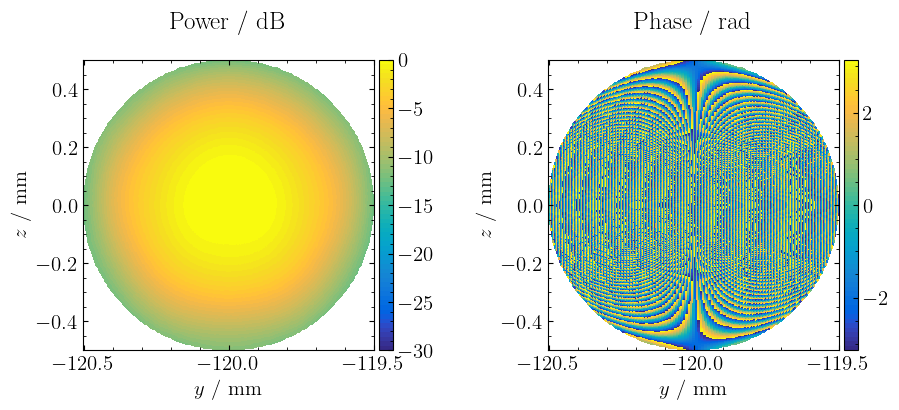

In [5]:
s.plotBeam2D("EH_par", FieldComponents.Ex, project=Projections.yz, vmin=-30, vmax=0)

We propagate the beam in the focus through the entire system onto the paraboloid reflector. We do not specify the "device" field in the PO dictionaries. This field defaults to "CPU" if the CUDA libraries are not compiled. If they are, the field defaults to "GPU". Similarly, the number of threads "nThreads" is not specified. If "device" = "CPU", "nThreads" defaults to the total number of CPU threads in your computer. If "device" = "GPU", "nThreads" defaults to 256 threads per CUDA block. In practice, this number is not critical and therefore does not have to be set often, but if set it should be a multiple of 32 (see [this link](https://en.wikipedia.org/wiki/Thread_block_(CUDA_programming)) for a good overview about CUDA blocks and threads).

We set, for the first two propagations, the "mode" parameter to "JM". This means we only store the calculated electric (J) and magnetic (M) currents on the target surface. If we specify "EH", such as for the last propagation, we only save the illuminating electric (E) and magnetic (H) field on the target surface. If we want both, we specify "mode" as "JMEH". Another option, "FF" for far-field, will be explained in more detail below. The last option, "EHP", stores the reflected field and corresponding Poynting vectors. With this option it is possible to do a combined ray-trace and PO approach. This will be introduced in a later tutorial.

In [6]:
plane_ff = {
            "name"      : "plane_ff",
            "gmode"     : "AoE",
            "lims_Az"    : np.array([-0.7, 0.7]) * 6,
            "lims_El"    : np.array([-0.7, 0.7]) * 6 - 90,
            "gridsize"  : np.array([301, 301])
            }
s.addPlane(plane_ff)

par_to_plane_ff_PO = {
    "t_name"      : "plane_ff",
    "s_current"   : "JM_par",
    "mode"        : "FF",
    "name_EH"     : "EH_FF",
    "nThreads"    : 256,
    "device"      : "GPU",
    "epsilon"     : 10
}

s.runPO(par_to_plane_ff_PO)

2025-08-28 15:02:04 - INFO - Added plane plane_ff to system. 
2025-08-28 15:02:04 - WORK - *** Starting PO propagation *** 
2025-08-28 15:02:04 - WORK - Propagating JM_par on paraboloid to plane_ff, propagation mode: FF. 
2025-08-28 15:02:04 - WORK - Hardware: running 256 CUDA threads per block. 
2025-08-28 15:02:04 - WORK - ... Calculating ... 
2025-08-28 15:02:05 - WORK - *** Finished: 0.753 seconds *** 


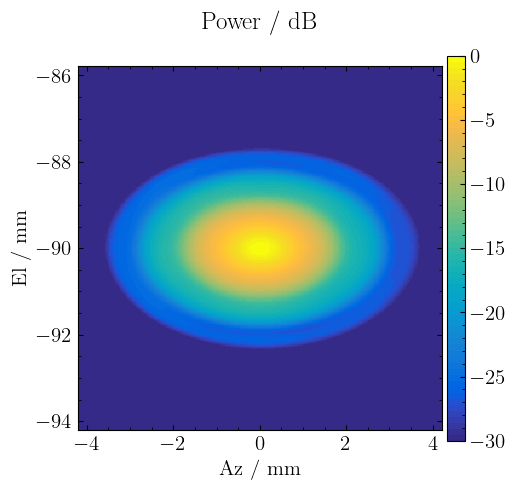

In [7]:
s.plotBeam2D("EH_FF", FieldComponents.Ex, vmin=-30, vmax=0, amp_only=True)

In this final section, we propagated the field from the paraboloid to the far-field. We did this by specifying the "gmode" parameter to "AoE", which stands for Azimuth-over-Elevation (the only far-field co-ordinate system currently present in `PyPO`). The limits in "AoE" mode were given in degrees. Note that we subtracted 90 degrees from the Elevation limits. This is because the paraboloid illuminates the far-field along the x-axis. Also, note that the xyz components of the resulting far-field object do not align with the axes shown in the system plot. This is because, in the resulting fields object, x now aligns with the field along the Azimuthal direction (the y-axis in the original co-ordinate system) and y points along the Elevation direction (the z-axis in the original co-ordinate system). 